# Оптимизация доходности: A/B-Анализ Гипотез для Интернет-Магазина

В сотрудничестве с отделом маркетинга, наша команда разработала ряд перспективных гипотез, нацеленных на максимизацию выручки. Теперь наша задача - взять управление в свои руки, приоритизировать эти гипотезы, провести A/B-тестирование, и, наконец, проанализировать полученные результаты.

План работы:
1. Предобработка данных
2. Приоритизация гипотез
3. Анализ A/B-теста
4. Решение по результатам теста

Оценка метрик А/В теста:
1. Кумулятивная выручка по группам
2. Кумулятивный средний чек по группам
3. Относительное изменение кумулятивного среднего чека группы B к группе A
4. Кумулятивное среднее количество заказов на посетителя по группам
5. Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A
6. Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным.
7. Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.
8. Подсчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.
9. Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным. 

Описание данных:
1. Файл /datasets/hypothesis.csv
    - Hypothesis — краткое описание гипотезы;
    - Reach — охват пользователей по 10-балльной шкале;
    - Impact — влияние на пользователей по 10-балльной шкале;
    - Confidence — уверенность в гипотезе по 10-балльной шкале;
    - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
Данные для второй части
2. Файл /datasets/orders.csv
    - transactionId — идентификатор заказа;
    - visitorId — идентификатор пользователя, совершившего заказ;
    - date — дата, когда был совершён заказ;
    - revenue — выручка заказа;
    - group — группа A/B-теста, в которую попал заказ.
3. Файл /datasets/visitors.csv
    - date — дата;
    - group — группа A/B-теста;
    - visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import datetime as dt

## Приоритизация гипотез

In [2]:
# Сохраним файл с гипотезами в переменную
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
pd.options.display.max_colwidth = 100

In [4]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
# Приведем названия столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()

In [6]:
# Проверим, есть ли дупликаты
hypothesis.duplicated().sum()

0

In [7]:
# Добавим столбец ICE для приоритизации гипотез и отсортируем их по убыванию приоритета.
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)

hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [8]:
# Добавим столбец RICE для приоритизации гипотез и отсортируем их по убыванию приоритета.
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Вывод по приоритизации гипотез
- Показатель ICE наибольший у гипотез:
    1. "Запустить акцию, дающую скидку на товар в день рождения"(16.2)
    2. "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"(13.3)
    3. "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"(11.2)
    4. "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"(8.0) 
- Показатель RICE наибольший у гипотез:
    1. "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"(112.0)
    2. "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек"(56.0)
    3. "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	"(40.0)
    4. "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"(40.0)
- Различия связаны с показателем reach(скольких пользователей затронет изменение). У 7 гипотезы ("Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок") данный показатель равен 10, в то время как у 8("Запустить акцию, дающую скидку на товар в день рождения") - 1, а у 0("Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей") - 3.

## Анализ A/B-теста

In [9]:
# Сохраним данные о пользователях и заказах в файлы visitors и orders, сразу перевем дату в тип datetime64
orders = pd.read_csv('/datasets/orders.csv', parse_dates=['date'])
visitors = pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])

### Анализ датасета orders

In [10]:
# Посмотрим информацию о датасете
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [11]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [12]:
# Проверим на пропуски
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [13]:
# Проверим на дубликаты
orders.duplicated().sum()

0

In [14]:
# Проверим правильность написания столбцов
orders.columns

Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')

In [15]:
# Убедимся, что существует только 2 группы
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [16]:
print(f'Тест проводился с {orders["date"].min()} по {orders["date"].max()}')

Тест проводился с 2019-08-01 00:00:00 по 2019-08-31 00:00:00


In [17]:
# Посмотрим, сколько пользователей попало в обе группы
users_in_group_A = set(orders[orders['group'] == 'A']['visitorId'])
users_in_group_B = set(orders[orders['group'] == 'B']['visitorId'])

users_in_both_groups = users_in_group_A.intersection(users_in_group_B)

# Теперь у вас есть множество пользователей, попавших в обе группы
num_users_in_both_groups = len(users_in_both_groups)
num_users_in_both_groups

58

In [18]:
total_users_in_both_groups = len(set(orders['visitorId']))
probability_of_intersection = num_users_in_both_groups / total_users_in_both_groups
print(f'Вероятность попадания пользователей в обе группы: {probability_of_intersection:.2%}')

Вероятность попадания пользователей в обе группы: 5.63%


**Вывод:**
- Тип данных в столбце date изменет с object на datetime64
- Пропуски не обнаружены
- Дубликаты не обнаружены
- 2 группы теста: A и B
- Тест проводился с 2019-08-01 по 2019-08-31
- 58 пользователей попало в обе группы
- Вероятность попадания пользователей в обе группы: 5.63%

### Анализ датасета visitors

In [19]:
# Посмотрим информацию о датасете
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [20]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [21]:
# Проверим на пропуски
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [22]:
# Проверим на дубликаты
visitors.duplicated().sum()

0

In [23]:
# Проверим правильность написания столбцов
visitors.columns

Index(['date', 'group', 'visitors'], dtype='object')

In [24]:
# Убедимся, что существует только 2 группы
visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [25]:
print(f'Тест проводился с {visitors["date"].min()} по {visitors["date"].max()}')

Тест проводился с 2019-08-01 00:00:00 по 2019-08-31 00:00:00


**Вывод:**
- Тип данных в столбце date изменет с object на datetime64
- Пропуски не обнаружены
- Дубликаты не обнаружены
- 2 группы теста: A и B
- Тест проводился с 2019-08-01 по 2019-08-31

### Построение графика кумулятивной выручки по группам

In [26]:
# Создадим датафрейм datesGroups с уникальными парами значений 'date' и 'group', таблицы orders. Избавимся от дубликатов методом drop_duplicates()
datesGroups = orders[['date', 'group']].drop_duplicates()
datesGroups.head(5)

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Объявим переменную ordersAggregated, содержащую:
- дату;
- группу A/B-теста;
- число уникальных заказов в группе теста по указанную дату включительно;
- число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
- суммарную выручку заказов в группе теста по указанную дату включительно.

In [27]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date' : 'max',
            'group' : 'max',
            'transactionId' : 'nunique',
            'visitorId' : 'nunique',
            'revenue' : 'sum'
        }
    ),
    axis=1
).sort_values(by=['date','group'])
ordersAggregated.head(5)

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Объявим переменную visitorsAggregated, содержащую:
- дату;
- группу A/B-теста;
- количество уникальных посетителей в группе теста по указанную дату включительно.

In [28]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date' : 'max',
            'group' : 'max',
            'visitors' : 'sum'
        }
    ),
    axis=1
).sort_values(by=['date','group'])
visitorsAggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [29]:
# Объявим переменную cumulativeData, , объединив ordersAggregated и visitorsAggregated по колонкам 'date', 'group'
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date', 
    'group', 
    'transactions', 
    'buyers', 
    'revenue', 
    'visitors'
]
cumulativeData.head(5)

,date,group,transactions,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [30]:
# Проверим, совпадают ли минимальная и максимальная даты в этом датафрейме с минимальной и максимальной датой в исходных данных
print(f'Тест проводился с {cumulativeData["date"].min()} по {cumulativeData["date"].max()}')

Тест проводился с 2019-08-01 00:00:00 по 2019-08-31 00:00:00


In [31]:
# Объявим переменные cumulativeRevenueA и cumulativeRevenueB, в которых сохраним данные о датах, выручке
# и числе заказов в группах A и B.
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][
    ['date','revenue', 'transactions']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][
    ['date','revenue', 'transactions']
]

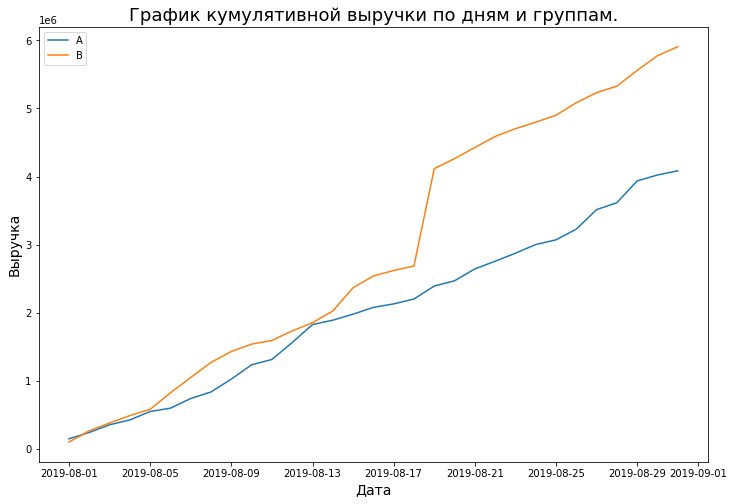

In [32]:
# Для каждой группы построим графики кумулятивной выручки по дням и группам
plt.figure(figsize=(12, 8))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по дням и группам.', fontsize=18)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Выручка', fontsize=14)
plt.legend() 

**Вывод:**
- Выручка почти равномерно увеличивается в течение всего теста
- Виден резкий рост в группе В в районе 19 числа. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

### Построение графика кумулятивного среднего чека по группам

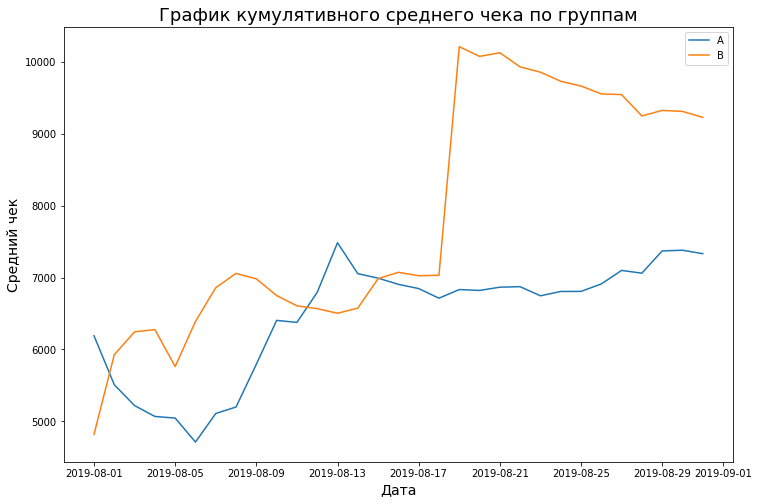

In [33]:
# Для каждой группы построим график кумулятивного среднего чека
plt.figure(figsize=(12, 8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['transactions'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['transactions'], label='B')
plt.title('График кумулятивного среднего чека по группам', fontsize=18)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Средний чек', fontsize=14)
plt.legend() 

**Вывод:**
- Средний чек становится равномерным ближе к концу теста. Для группы А параметр установился, для группы В падает.
-  Возможно, в группу B в районе 19 числа попали крупные заказы (резкий всплеск на графике). 

### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

Text(0, 0.5, '(Средний чек В / Средний чек А) - 1')

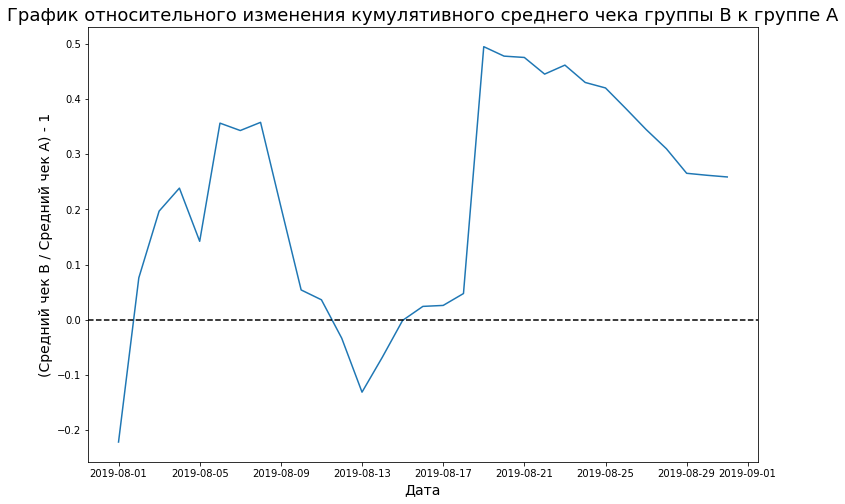

In [34]:
# Построение графика относительного изменения кумулятивного среднего чека группы B к группе A
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
# Строим отношение средних чеков
plt.figure(figsize=(12, 8))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['transactionsB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['transactionsA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=18)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('(Средний чек В / Средний чек А) - 1', fontsize=14)

**Вывод:**
- Заметны скачки графика в нескольких точках, что также сигнализирует нам о выбросах в виде крупных заказов.

### Построение графика кумулятивного среднего количества заказов на посетителя по группам

In [35]:
# Объявим переменные cumulativeTransactionsA и cumulativeTransactionsB, в которых сохраним данные о датах, заказах
# и числе посетителей в группах A и B.
cumulativeTransactionsA = cumulativeData[cumulativeData['group']=='A'][
    ['date','transactions', 'visitors']
]
cumulativeTransactionsB = cumulativeData[cumulativeData['group']=='B'][
    ['date','transactions', 'visitors']
]

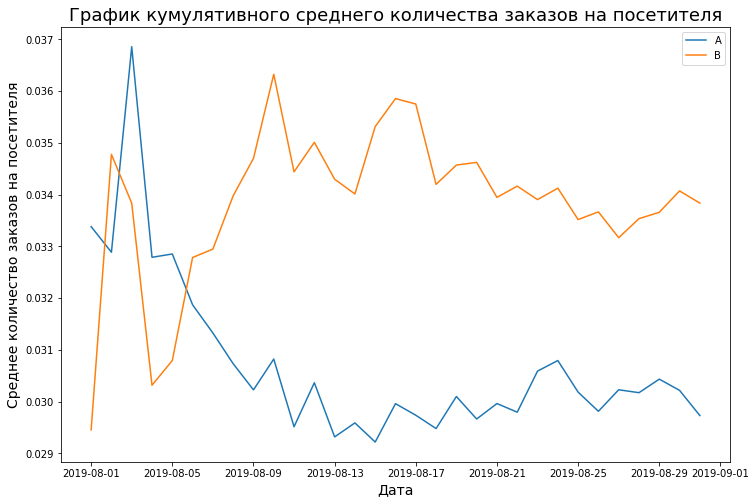

In [36]:
# Для каждой группы построим график кумулятивного среднего количества заказов на посетителя
plt.figure(figsize=(12, 8))
plt.plot(cumulativeTransactionsA['date'], cumulativeTransactionsA['transactions']/cumulativeTransactionsA['visitors'], label='A')
plt.plot(cumulativeTransactionsB['date'], cumulativeTransactionsB['transactions']/cumulativeTransactionsB['visitors'], label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя', fontsize=18)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Среднее количество заказов на посетителя', fontsize=14)
plt.legend() 

**Вывод:**
- К концу теста параметр для обеих групп почти зафиксировался, хотя и видны флуктационные изменения.
- Среднее кол-во заказов для группы В значительно выше

### Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

Text(0, 0.5, 'Среднее количество заказов на посетителя В / Среднее количество заказов на посетителя A')

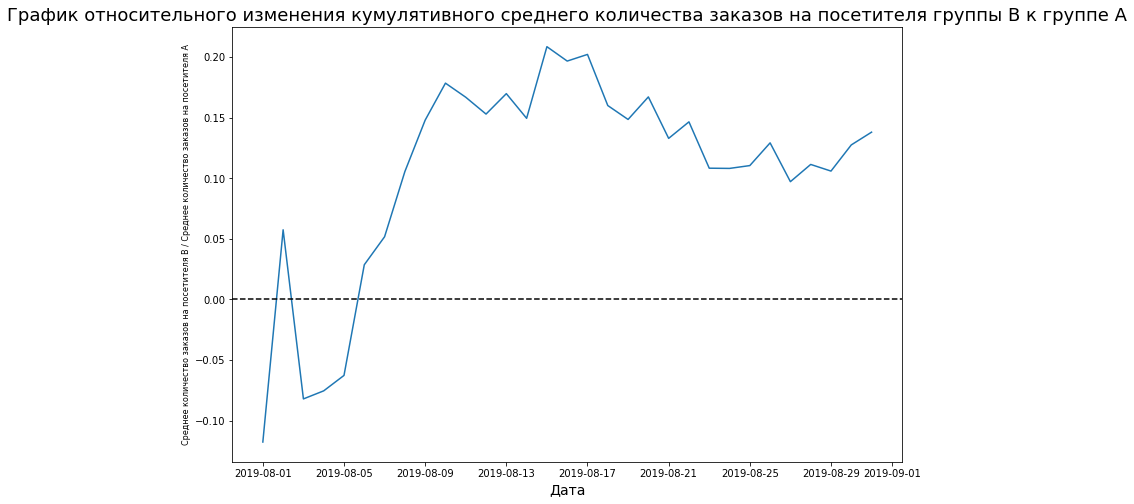

In [37]:
# Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A
mergedCumulativeTransactions = cumulativeTransactionsA.merge(cumulativeTransactionsB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 8))
plt.plot(mergedCumulativeTransactions['date'], (mergedCumulativeTransactions['transactionsB']/mergedCumulativeTransactions['visitorsB'])/(mergedCumulativeTransactions['transactionsA']/mergedCumulativeTransactions['visitorsA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A', fontsize=18)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Среднее количество заказов на посетителя В / Среднее количество заказов на посетителя A', fontsize=8)

**Вывод:**
- В самом начале теста группа В проигрывала группе А, затем вырвалась вперёд и в последнии дни демонстрирует относительный рост

### Построение точечного графика количества заказов по пользователям

In [38]:
# Сохраним в переменную таблицу с пользователями и кол-вом заказов
visitors_transactions = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
visitors_transactions.columns = ['visitorId', 'transactions'] 
visitors_transactions.head(5)

,visitorId,transactions
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


Text(0.5, 0, 'Пользователи')

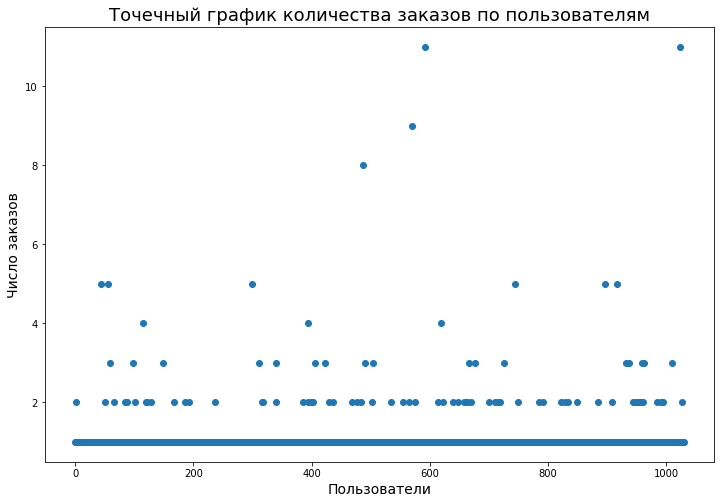

In [39]:
# Построение точечного графика количества заказов по пользователям
x_values = pd.Series(range(0, len(visitors_transactions['transactions'])))
plt.figure(figsize=(12, 8))
plt.scatter(x_values, visitors_transactions['transactions'])
plt.title('Точечный график количества заказов по пользователям', fontsize=18)
plt.ylabel('Число заказов', fontsize=14)
plt.xlabel('Пользователи', fontsize=14) 

**Вывод:**
- На графике видны аномальные пользователи, совершившие больше 3 заказов. Подавляющее большинство пользователей совершили до 2 заказов.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [40]:
print(np.percentile(visitors_transactions['transactions'],[95, 99]))

[2. 4.]


**Вывод:**
- Не более 5% пользователей совершили более 2 заказов и не более 1% больше 4 заказов.
- Разумно выбрать 4 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

### Построение точечного графика стоимостей заказов. 

Text(0.5, 0, 'Пользователи')

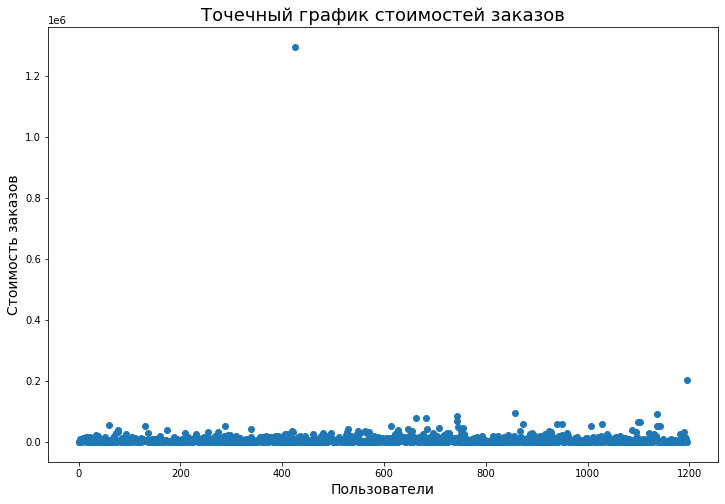

In [41]:
# Построение точечного графика стоимостей заказов
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(12, 8))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов', fontsize=18)
plt.ylabel('Стоимость заказов', fontsize=14)
plt.xlabel('Пользователи', fontsize=14) 

**Вывод:**
- На графике видны пара заметных выбросов.
- По большей части все заказы имеют похожую стоимость

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [42]:
print(np.percentile(orders['revenue'],[95, 99]))

[28000.  58233.2]


**Вывод:**
- Не более 5% заказов стоят больше 28000 и не более 1% больше 58233.2.
- В данном случае выберем верхней границей стоимость заказа в 28000.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

In [43]:
# Посчитаем количество пользователей в указанную дату в группе А 
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
# Посчитаем кумулятивное количество пользователей в указанную дату в группе А 
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsACummulative.head(5)

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [44]:
# Посчитаем количество пользователей в указанную дату в группе B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
# Посчитаем кумулятивное количество пользователей в указанную дату в группе B 
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
visitorsBCummulative.head(5)

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [45]:
# Посчитаем кол-во заказов в группе А
transactionsADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
transactionsADaily.columns = ['date', 'transactionsPerDateA', 'revenuePerDateA']
# Посчитаем кумулятивное кол-во заказов в группе А
transactionsACummulative = transactionsADaily.apply(
    lambda x: transactionsADaily[transactionsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'transactionsPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
transactionsACummulative.columns = [
    'date',
    'transactionsCummulativeA',
    'revenueCummulativeA',
]
transactionsACummulative.head(5)

,date,transactionsCummulativeA,revenueCummulativeA
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


In [46]:
# Посчитаем кол-во заказов в группе В
transactionsBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
transactionsBDaily.columns = ['date', 'transactionsPerDateB', 'revenuePerDateB']
# Посчитаем кумулятивное кол-во заказов в группе В
transactionsBCummulative = transactionsBDaily.apply(
    lambda x: transactionsBDaily[transactionsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'transactionsPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
transactionsBCummulative.columns = [
    'date',
    'transactionsCummulativeB',
    'revenueCummulativeB',
]
transactionsBDaily.head(5)

,date,transactionsPerDateB,revenuePerDateB
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248
3,2019-08-04,17,108571
4,2019-08-05,23,92428


In [47]:
# Составим общую таблицу из предыдущих
data = (
    transactionsADaily.merge(
        transactionsBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(transactionsACummulative, left_on='date', right_on='date', how='left')
    .merge(transactionsBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
data.head(5)

,date,transactionsPerDateA,revenuePerDateA,transactionsPerDateB,revenuePerDateB,transactionsCummulativeA,revenueCummulativeA,transactionsCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [48]:
# Посчитаем кол-во заказов каждого пользователя в группе А
transactionsByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
transactionsByUsersA.columns = ['visitorId', 'transactions']
transactionsByUsersA.head(5)                          

,visitorId,transactions
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [49]:
# Посчитаем кол-во заказов каждого пользователя в группе В
transactionsByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
transactionsByUsersB.columns = ['visitorId', 'transactions']
transactionsByUsersB.head(5)

,visitorId,transactions
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


In [50]:
# Объявим переменную sampleA, в которую пользователям с заказами будет соответствовать число заказов пользователя.
# А пользователям без заказов — нули. 
sampleA = pd.concat(
    [
        transactionsByUsersA['transactions'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(transactionsByUsersA['transactions'])
            ),
            name='transactions',
        ),
    ],
    axis=0,
)
sampleA.head(-5)

0        1
1        1
2        1
3        1
4        1
        ..
18223    0
18224    0
18225    0
18226    0
18227    0
Name: transactions, Length: 18731, dtype: int64

In [51]:
# Объявим переменную sampleB, в которую пользователям с заказами будет соответствовать число заказов пользователя.
# А пользователям без заказов — нули.
sampleB = pd.concat(
    [
        transactionsByUsersB['transactions'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(transactionsByUsersB['transactions'])
            ),
            name='transactions',
        ),
    ],
    axis=0,
)
sampleB.head(-5)

0        1
1        1
2        1
3        1
4        1
        ..
18320    0
18321    0
18322    0
18323    0
18324    0
Name: transactions, Length: 18911, dtype: int64

- Нулевая гипотеза : по «сырым» данным различий в среднем числе заказов групп A и B нет.
- Альтернативная гипотеза : по «сырым» данным есть различие в среднем числе заказов групп A и B.

In [52]:
alpha = 0.05  # критический уровень статистической значимости
results = stats.mannwhitneyu(sampleA, sampleB)[1]
print("p-значение: {0:.3f}".format(results))
if results < alpha:
    print('Отвергаем нулевую гипотезу: : по «сырым» данным есть различие в среднем числе заказов групп A и B.')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, по «сырым» данным различий в среднем числе заказов групп A и B нет. '
    ) 
#  Относительный прирост среднего числа заказов группы B

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-значение: 0.017
Отвергаем нулевую гипотезу: : по «сырым» данным есть различие в среднем числе заказов групп A и B.
0.138


**Вывод:**
- p-значение: 0.017
- Отвергаем нулевую гипотезу: : по «сырым» данным есть различие в среднем числе заказов групп A и B.
- Относительный прирост среднего числа заказов группы B : 13,8%

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

- Нулевая гипотеза : по «сырым» данным различий в среднем чеке заказа между группами A и B нет.
- Альтернативная гипотеза : по «сырым» данным есть различие в среднем чеке заказа между группами A и B.

In [53]:
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
print("p-значение: {0:.3f}".format(results))
if results < alpha:
    print('Отвергаем нулевую гипотезу: : по «сырым» данным различий в среднем чеке заказа между группами A и B нет')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, по «сырым» данным есть различие в среднем чеке заказа между группами A и B'
    ) 

print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-значение: 0.729
Не получилось отвергнуть нулевую гипотезу, по «сырым» данным есть различие в среднем чеке заказа между группами A и B
0.259


**Вывод:**
- p-значение: 0.729
- Не получилось отвергнуть нулевую гипотезу, по «сырым» данным различий в среднем чеке заказа между группами A и B нет.
- Средний чек группы A значительно меньше, разница в 25,9%

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

In [54]:
# Сделаем срез пользователей с числом заказов больше 4
usersWithManyOrders = pd.concat(
    [
        transactionsByUsersA[transactionsByUsersA['transactions'] > 4]['visitorId'],
        transactionsByUsersB[transactionsByUsersB['transactions'] > 4]['visitorId'],
    ],
    axis=0,
)
# Сделаем срез пользователей, совершивших заказы дороже 28 000
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
# Объединим их в таблице abnormalUsers
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print('Число аномальных пользователей = ', usersWithExpensiveOrders.count())

Число аномальных пользователей =  60


In [55]:
# Cохраним очищенные данные о заказах, не включая аномальных пользователей группы А.
sampleAFiltered = pd.concat(
    [
        transactionsByUsersA[
            np.logical_not(transactionsByUsersA['visitorId'].isin(abnormalUsers))
        ]['transactions'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(transactionsByUsersA['transactions'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sampleAFiltered.head(-5)

0        1
1        1
2        1
3        1
4        1
        ..
18223    0
18224    0
18225    0
18226    0
18227    0
Length: 18698, dtype: int64

In [56]:
# Cохраним очищенные данные о заказах, не включая аномальных пользователей группы В.
sampleBFiltered = pd.concat(
    [
        transactionsByUsersB[
            np.logical_not(transactionsByUsersB['visitorId'].isin(abnormalUsers))
        ]['transactions'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(transactionsByUsersB['transactions'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
sampleBFiltered.head(-5)

0        1
1        1
2        1
3        1
4        1
        ..
18320    0
18321    0
18322    0
18323    0
18324    0
Length: 18874, dtype: int64

- Нулевая гипотеза : по «очищенным» данным различий в среднем числе заказов групп A и B нет.
- Альтернативная гипотеза : по «очищенным» данным есть различие в среднем числе заказов групп A и B.

In [57]:
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
print("p-значение: {0:.3f}".format(results))
if results < alpha:
    print('Отвергаем нулевую гипотезу: : по «очищенным» данным есть различие в среднем числе заказов групп A и B.')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, по «очищенным» данным различий в среднем числе заказов групп A и B нет. '
    ) 
#  Относительный прирост среднего числа заказов группы B

print("{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-значение: 0.018
Отвергаем нулевую гипотезу: : по «очищенным» данным есть различие в среднем числе заказов групп A и B.
0.145


**Вывод:**
- p-значение: 0.018
- Отвергаем нулевую гипотезу: : по «очищенным» данным есть различие в среднем числе заказов групп A и B.
- Относительный прирост среднего числа заказов группы B : 14,5%

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

- Нулевая гипотеза : по «очищенным» данным различий в среднем чеке заказа между группами A и B нет.
- Альтернативная гипотеза : по «очищенным» данным есть различие в среднем чеке заказа между группами A и B.

In [58]:
results = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
print("p-значение: {0:.3f}".format(results))
if results < alpha:
    print('Отвергаем нулевую гипотезу: : по «очищенным» данным различий в среднем чеке заказа между группами A и B нет.')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, по «очищенным» данным есть различие в среднем чеке заказа между группами A и B.'
    ) 

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-значение: 0.961
Не получилось отвергнуть нулевую гипотезу, по «очищенным» данным есть различие в среднем чеке заказа между группами A и B.
-0.014


**Вывод:**
- p-значение: 0.961
- Не получилось отвергнуть нулевую гипотезу, по «очищенным» данным различий в среднем чеке заказа между группами A и B нет.
- Средний чек группы A не значительно больше, разница в 1,4%

### Общий вывод по анализу A/B-теста

1. Анализ датасета orders
    - Тип данных в столбце date изменет с object на datetime64
    - Пропуски не обнаружены
    - Дубликаты не обнаружены
    - 2 группы теста: A и B
    - Тест проводился с 2019-08-01 по 2019-08-31
    - 58 пользователей попало в обе группы
    - Вероятность попадания пользователей в обе группы: 5.63%
2. Анализ датасета visitors
    - Тип данных в столбце date изменит с object на datetime64
    - Пропуски не обнаружены
    - Дубликаты не обнаружены
    - 2 группы теста: A и B
    - Тест проводился с 2019-08-01 по 2019-08-31
3.  Построение графика кумулятивной выручки по группам
    - Выручка почти равномерно увеличивается в течение всего теста
    - Виден резкий рост в группе В в районе 19 числа. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.
4. Построение графика кумулятивного среднего чека по группам
    - Средний чек становится равномерным ближе к концу теста. Для группы А параметр установился, для группы В падает.
    -  Возможно, в группу B в районе 19 числа попали крупные заказы (резкий всплеск на графике). 
5. Построение графика относительного изменения кумулятивного среднего чека группы B к группе A
    - Заметны скачки графика в нескольких точках, что также сигнализирует нам о выбросах в виде крупных заказов.
6. Построение графика кумулятивного среднего количества заказов на посетителя по группам
    - К концу теста параметр для обеих групп почти зафиксировался, хотя и видны флуктационные изменения.
    - Среднее кол-во заказов для группы В значительно выше
7. Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A
    - В самом начале теста группа В проигрывала группе А, затем вырвалась вперёд и в последние дни демонстрирует относительный рост
8. Построение точечного графика количества заказов по пользователям
    - На графике видны аномальные пользователи, совершившие больше 3 заказов. Подавляющее большинство пользователей совершили до 2 заказов.
9.  Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.
    - Не более 5% пользователей совершили более 2 заказов и не более 1% больше 4 заказов.
    - Разумно выбрать 4 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.
10. Построение точечного графика стоимостей заказов.
    - На графике видны пара заметных выбросов.
    - По большей части все заказы имеют похожую стоимость
11. Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.
    - Не более 5% заказов стоят больше 28000 и не более 1% больше 58233.2.
    - В данном случае выберем верхней границей стоимость заказа в 28000.
12. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.
    - p-значение: 0.017
    - Отвергаем нулевую гипотезу: : по «сырым» данным есть различие в среднем числе заказов групп A и B.
    - Относительный прирост среднего числа заказов группы B : 13,8%
13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.
    - p-значение: 0.729
    - Не получилось отвергнуть нулевую гипотезу, по «сырым» данным различий в среднем чеке заказа между группами A и B нет.
    - Средний чек группы A значительно меньше, разница в 25,9%
14.  Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.
    - p-значение: 0.018
    - Отвергаем нулевую гипотезу: : по «очищенным» данным есть различие в среднем числе заказов групп A и B.
    - Относительный прирост среднего числа заказов группы B : 14,5%
    - Таким образом, даже после осеивания аномальных пользователей, по «очищенным» данным есть различие в среднем числе заказов групп A и B.
15. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.
    - p-значение: 0.961
    - Не получилось отвергнуть нулевую гипотезу, по «очищенным» данным различий в среднем чеке заказа между группами A и B нет.
    - Средний чек группы A не значительно больше, разница в 1,4%, хотя в сырых данных разница составляла 25,9%

## Результаты

1. Есть статистически значимое различие по числу заказов между группами как по сырым данным, так и после очистки аномалий.
2. По сырым данным, как и после очистки, нет статистически значимого различия по среднему чеку между группами.
3. График кумулятивной выручки по дням и группам сообщает, что результаты группы B лучше группы A: обе группы имеют тенденцию к росту, но группа В опережает.
4. По графику относительного изменения кумулятивного среднего чека группы B к группе A нельзя сделать определенных выводов. Заметны скачки графика в нескольких точках, что сигнализирует нам о выбросах в виде крупных заказов.
5. График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A, сообщает, что группа В демонстрирует лучшие результаты. Также видна небольшая тенденция к росту группы В.
6. **Достигнута статистическая значимость: число заказов в группе В больше. Смысла продолжать тест нет.**